# Hierarchical Agent Teams

In our previous example ([Agent Supervisor](./agent_supervisor.ipynb)), we introduced the concept of a single supervisor node to route work between different worker nodes.

But what if the job for a single worker becomes too complex? What if the number of workers becomes too large?

For some applications, the system may be more effective if work is distributed _hierarchically_.

You can do this by composing different subgraphs and creating a top-level supervisor, along with mid-level supervisors.

To do this, let's build a simple research assistant! The graph will look something like the following:

![diagram](./img/hierarchical-diagram.png)

This notebook is inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al. In the rest of this notebook, you will:

1. Define the agents' tools to access the web and write files
2. Define some utilities to help create the graph and agents
3. Create and define each team (web research + doc writing)
4. Compose everything together.

But before all of that, some setup:

In [12]:
// Deno.env.set("OPENAI_API_KEY", "sk_...");
// Deno.env.set("TAVILY_API_KEY", "sk_...");

// Optional, add tracing in LangSmith
// Deno.env.set("LANGCHAIN_API_KEY", "sk_...");
// Deno.env.set("LANGCHAIN_TRACING_V2", "true");
// Deno.env.set("LANGCHAIN_PROJECT", "Multi-agent Collaboration: LangGraphJS");

In [13]:
import "dotenv/config";

[Module: null prototype] { default: {} }

## Create Tools

Each team will be composed of one or more agents each with one or more tools. Below, define all the tools to be used by your different teams.

We'll start with the research team.

**Research team tools**

The research team can use a search engine and url scraper to find information on the web. Feel free to add additional functionality below to boost the team performance!

In [14]:
import { TavilySearchResults } from "@langchain/community/tools/tavily_search";
import { CheerioWebBaseLoader } from "langchain/document_loaders/web/cheerio";
import { DynamicStructuredTool } from "@langchain/core/tools";
import { z } from "zod";

const tavilyTool = new TavilySearchResults();

// Note: to run this in jupyter, will need to set an import map in deno.json
const scrapeWebpage = new DynamicStructuredTool({
  name: "scrape_webpage",
  description: "Scrape the contents of a webpage.",
  schema: z.object({
    url: z.string(),
  }),
  func: async ({ url }) => {
    const loader = new CheerioWebBaseLoader(url);
    const docs  = await loader.load();
    const formattedDocs = docs.map(
      (doc) =>
        `<Document name="${doc.metadata?.title}">\n${doc.pageContent}\n</Document>`
    );
    return formattedDocs.join("\n\n");
  },
});


**Document writing team tools**

Next up, we will give some tools for the doc writing team to use.
We define some bare-bones file-access tools below.

Note that this gives the agents access to your file-system, which can be unsafe. We also haven't optimized the tool descriptions for performance.

In [15]:
import * as d3 from "d3";
import { createCanvas } from "https://deno.land/x/skia_canvas/mod.ts";

const WORKING_DIRECTORY = Deno.makeTempDirSync();

const createOutlineTool = new DynamicStructuredTool({
  name: "create_outline",
  description: "Create and save an outline.",
  schema: z.object({
    points: z
      .array(z.string())
      .nonempty("List of main points or sections must not be empty."),
    file_name: z.string(),
  }),
  func: async ({ points, file_name }) => {
    const filePath = `${WORKING_DIRECTORY}/${file_name}`;
    const data = points
      .map((point, index) => `${index + 1}. ${point}\n`)
      .join("");
    await Deno.writeTextFile(filePath, data);
    return `Outline saved to ${file_name}`;
  },
});

const readDocumentTool = new DynamicStructuredTool({
  name: "read_document",
  description: "Read the specified document.",
  schema: z.object({
    file_name: z.string(),
    start: z.number().optional(),
    end: z.number().optional(),
  }),
  func: async ({ file_name, start, end }) => {
    const filePath = `${WORKING_DIRECTORY}/${file_name}`;
    const data = await Deno.readTextFile(filePath);
    const lines = data.split("\n");
    return lines.slice(start ?? 0, end).join("\n");
  },
});

const writeDocumentTool = new DynamicStructuredTool({
  name: "write_document",
  description: "Create and save a text document.",
  schema: z.object({
    content: z.string(),
    file_name: z.string(),
  }),
  func: async ({ content, file_name }) => {
    const filePath = `${WORKING_DIRECTORY}/${file_name}`;
    await Deno.writeTextFile(filePath, content);
    return `Document saved to ${file_name}`;
  },
});

const editDocumentTool = new DynamicStructuredTool({
  name: "edit_document",
  description: "Edit a document by inserting text at specific line numbers.",
  schema: z.object({
    file_name: z.string(),
    inserts: z.record(z.number(), z.string()),
  }),
  func: async ({ file_name, inserts }) => {
    const filePath = `${WORKING_DIRECTORY}/${file_name}`;
    const data = await Deno.readTextFile(filePath);
    let lines = data.split("\n");

    const sortedInserts = Object.entries(inserts).sort(
      ([a], [b]) => parseInt(a) - parseInt(b)
    );

    for (const [line_number_str, text] of sortedInserts) {
      const line_number = parseInt(line_number_str);
      if (1 <= line_number && line_number <= lines.length + 1) {
        lines.splice(line_number - 1, 0, text);
      } else {
        return `Error: Line number ${line_number} is out of range.`;
      }
    }

    await Deno.writeTextFile(filePath, lines.join("\n"));
    return `Document edited and saved to ${file_name}`;
  },
});

const chartTool = new DynamicStructuredTool({
  name: "generate_bar_chart",
  description:
    "Generates a bar chart from an array of data points using D3.js and displays it for the user.",
  schema: z.object({
    data: z
      .object({
        label: z.string(),
        value: z.number(),
      })
      .array(),
  }),
  func: async ({data}) => {
    // const data = input.data;
    const width = 500;
    const height = 500;
    const margin = { top: 20, right: 30, bottom: 30, left: 40 };

    const canvas = createCanvas(width, height);
    const ctx = canvas.getContext("2d");

    const x = d3
      .scaleBand()
      .domain(data.map((d) => d.label))
      .range([margin.left, width - margin.right])
      .padding(0.1);

    const y = d3
      .scaleLinear()
      .domain([0, d3.max(data, (d) => d.value)])
      .nice()
      .range([height - margin.bottom, margin.top]);

    const colorPalette = [
      "#e6194B",
      "#3cb44b",
      "#ffe119",
      "#4363d8",
      "#f58231",
      "#911eb4",
      "#42d4f4",
      "#f032e6",
      "#bfef45",
      "#fabebe",
    ];

    data.forEach((d, idx) => {
      ctx.fillStyle = colorPalette[idx % colorPalette.length];
      ctx.fillRect(
        x(d.label),
         y(d.value),
        x.bandwidth(),
        height - margin.bottom - y(d.value),
      );
    });

    ctx.beginPath();
    ctx.strokeStyle = "black";
    ctx.moveTo(margin.left, height - margin.bottom);
    ctx.lineTo(width - margin.right, height - margin.bottom);
    ctx.stroke();

    ctx.textAlign = "center";
    ctx.textBaseline = "top";
    x.domain().forEach((d) => {
      const xCoord = x(d) + x.bandwidth() / 2;
      ctx.fillText(d, xCoord, height - margin.bottom + 6);
    });

    ctx.beginPath();
    ctx.moveTo(margin.left, height - margin.top);
    ctx.lineTo(margin.left, height - margin.bottom);
    ctx.stroke();

    ctx.textAlign = "right";
    ctx.textBaseline = "middle";
    const ticks = y.ticks();
    ticks.forEach((d) => {
      const yCoord = y(d); // height - margin.bottom - y(d);
      ctx.moveTo(margin.left, yCoord);
      ctx.lineTo(margin.left - 6, yCoord);
      ctx.stroke();
      ctx.fillText(d, margin.left - 8, yCoord);
    });

    await Deno.jupyter.display(canvas);
    return "Chart has been generated and displayed to the user!";
  },
});

In [16]:
// Example invocation
await writeDocumentTool.invoke({content: "Hello from LangGraph!", file_name: "hello.txt"});

"Document saved to hello.txt"

In [17]:
await readDocumentTool.invoke({file_name: "hello.txt"});

"Hello from LangGraph!"

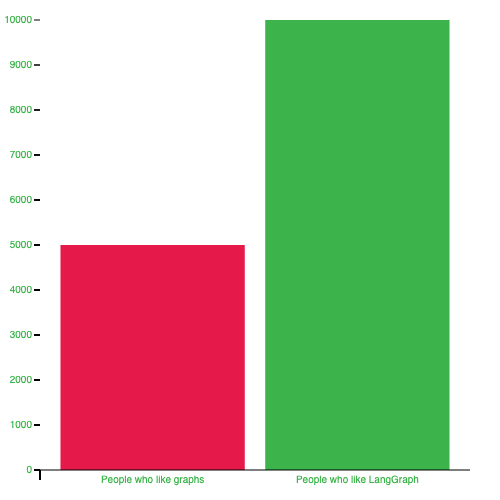

"Chart has been generated and displayed to the user!"

In [18]:
await chartTool.invoke({data: [{label: "People who like graphs", value: 5000}, {label: "People who like LangGraph", value: 10000}]});

## Helper Utilities

We are going to create a few utility functions to make it more concise when we want to:

1. Create a worker agent.
2. Create a supervisor for the sub-graph.

These will simplify the graph compositional code at the end for us so it's easier to see what's going on.

In [19]:
import { AgentExecutor, createOpenAIToolsAgent } from "langchain/agents";
import { HumanMessage } from "@langchain/core/messages";
import { ChatPromptTemplate, MessagesPlaceholder } from "@langchain/core/prompts";
import { JsonOutputToolsParser } from "langchain/output_parsers";
import { ChatOpenAI } from "@langchain/openai";
import { Runnable } from "@langchain/core/runnables";
import { BaseTool } from "@langchain/core/tools";

async function createAgent(
  llm: ChatOpenAI, 
  tools: BaseTool[], 
  systemPrompt: string
): Promise<Runnable> {
  const combinedPrompt = (
    systemPrompt + 
    "\nWork autonomously according to your specialty, using the tools available to you." + 
        " Do not ask for clarification." +
      " Your other team members (and other teams) will collaborate with you with their own specialties." +
      " You are chosen for a reason! You are one of the following team members: {team_members}."
  );
  const toolNames = tools.map((t) => t.name).join(", ");
  const prompt = await ChatPromptTemplate.fromMessages([
    ["system", combinedPrompt],
    new MessagesPlaceholder("messages"),
    new MessagesPlaceholder("agent_scratchpad"),
    [
      "system", 
      [
        "Supervisor instructions: {instructions}\n" +
        `Remember, you individually can only use these tools: ${toolNames}`+
        "\n\nEnd if you have already completed the requested task. Communicate the work completed." 
      ].join("\n")
    ],
  ]);
  const agent = await createOpenAIToolsAgent({ llm, tools, prompt });
  return new AgentExecutor({ agent, tools });
}

async function runAgentNode(
  { state, agent, name }: { state: any, agent: AgentExecutor, name: string }
) {
  const result = await agent.invoke(state);
  return {
    messages: [
      new HumanMessage({ content: result.output, name }),
    ]
  };
}

async function createTeamSupervisor(
  llm: ChatOpenAI,
  systemPrompt: string, 
  members: string[]
): Promise<Runnable> {
  const options = ["FINISH", ...members];
  const functionDef = {
    name: "route",
    description: "Select the next role.",
    parameters: {
      title: "routeSchema",
      type: "object",
      properties: {
        reasoning: {
          title: "Reasoning",
          type: "string",
        },
        next: {
          title: "Next",
          anyOf: [
            { enum: options },
          ],
        },
        instructions: {
          title: "Instructions",
          type: "string",
          description: "The specific instructions of the sub-task the next role should accomplish.",
        },
      },
      required: ["reasoning", "next", "instructions"],
    },
  };
  const toolDef = {
    type: "function",
    function: functionDef,
  };
  let prompt = await ChatPromptTemplate.fromMessages([
    ["system", systemPrompt],
    new MessagesPlaceholder("messages"),
    [
      "system",
      "Given the conversation above, who should act next? Or should we FINISH? Select one of: {options}",
    ],
  ])
  prompt = await prompt.partial({ options: options.join(", "), team_members: members.join(", ") });

  const supervisor = prompt
    .pipe(llm.bind({
      tools: [toolDef],
      tool_choice: {"type": "function", "function": {"name": "route"}}
    }))
    .pipe(new JsonOutputToolsParser())
    // select the first one
    .pipe((x) => ({
      next: x[0].args.next,
      instructions: x[0].args.instructions,
    }));
  
  return supervisor; 
}

## Define Agent Teams

Now we can get to define our hierachical teams. "Choose your player!"

### Research Team

The research team will have a search agent and a web scraping "research_agent" as the two worker nodes. Let's create those, as well as the team supervisor. (Note: If you are running deno in a jupyter notebook, the web scraper won't work out of the box. We have commented out this code to accomodate this challenge)

In [20]:
import { BaseMessage } from "@langchain/core/messages";
import { ChatOpenAI } from "@langchain/openai";

// Define the ResearchTeamState type
interface ResearchTeamState {
  messages: BaseMessage[];
  team_members: string[];
  next: string;
  instructions: string
}

// This defines the agent state for the research team
const researchTeamState: ResearchTeamState = {
  messages: {
    value: (x: BaseMessage[], y: BaseMessage[]) => x.concat(y),
    default: () => [],
  },
  team_members: [],
  next: "initialValueForNext",
  instructions: "Solve the human's question.",
};

const llm = new ChatOpenAI({modelName: "gpt-4-1106-preview"});

// Assuming createAgent and createTeamSupervisor are the same functions you defined earlier
const searchAgent = await createAgent(
  llm,
  [tavilyTool],
  "You are a research assistant who can search for up-to-date info using the tavily search engine."
);
const searchNode = (state: ResearchTeamState) => {
  return runAgentNode({ state, agent: searchAgent, name: "Search" });
};

// Uncomment if you have your import map set up correctly
// const researchAgent = await createAgent(
//   llm,
//   [scrapeWebpages],
//   "You are a research assistant who can scrape specified urls for more detailed information using the scrapeWebpages function."
// );
// const researchNode = (state: ResearchTeamState) =>
//   agentNode({ state, agent: researchAgent, name: "Web Scraper" });

const supervisorAgent = await createTeamSupervisor(
  llm,
  "You are a supervisor tasked with managing a conversation between the" +
    " following workers:  {team_members}. Given the following user request," +
    " respond with the worker to act next. Each worker will perform a" +
    " task and respond with their results and status. When finished," +
    " respond with FINISH.\n\n" + 
    " Select strategically to minimize the number of steps taken.",
      ["Search"] // , "Web Scraper"]
);


Now that we've created the necessary components, defining their interactions is easy. Add the nodes to the team graph, and define the edges, which determine the transition criteria.

In [21]:
import { StateGraph, END } from "@langchain/langgraph";

const researchGraph = new StateGraph({
  channels: researchTeamState,
});

researchGraph.addNode("Search", searchNode);
researchGraph.addNode("supervisor", supervisorAgent);

// Define the control flow
researchGraph.addEdge("Search", "supervisor");
researchGraph.addConditionalEdges(
  "supervisor",
  ((x) => x.next),
  {
    Search: "Search",
    FINISH: END
  }
);

researchGraph.setEntryPoint("supervisor");
const researchChain = researchGraph.compile();

Since each team is itself a complete computational graph, you can directly query it like so:

In [22]:
const streamResults = researchChain.stream(
  { messages: [new HumanMessage("What's the price of a big mac in Argentina?")] },
  { recursionLimit: 100 },
)
for await (const output of await streamResults) {
  if (!output?.__end__){
    console.log(output);
    console.log('----');
  }
}

{
  supervisor: {
    next: "Search",
    instructions: "Please find the current price of a Big Mac in Argentina."
  }
}
----
{
  Search: {
    messages: [
      HumanMessage {
        lc_serializable: true,
        lc_kwargs: {
          content: "The current price of a Big Mac in Argentina is 6.11 USD as of December 2023.",
          name: "Search",
          additional_kwargs: {}
        },
        lc_namespace: [ "langchain_core", "messages" ],
        content: "The current price of a Big Mac in Argentina is 6.11 USD as of December 2023.",
        name: "Search",
        additional_kwargs: {}
      }
    ]
  }
}
----
{
  supervisor: {
    next: "FINISH",
    instructions: "The information requested by the user has been provided."
  }
}
----


You can [click here](https://smith.langchain.com/public/6d9bf294-960d-407f-81fe-2dc1838add4f/r) to see a LangSmith trace of the above run.

### Document Writing Team

Create the document writing team below using a similar approach. This time, we will give each agent access to different file-writing tools.

Note that we are giving file-system access to our agent here, which is not safe in all cases. 

For the doc writing team, each agent will be writing to the same workspace. We don't want them to waste time checking which files are available, so we will force a call to a "prelude" function before an agent is invoked to populate the
prompt template with the current directory's contents.

In [23]:
import { RunnableLambda } from "@langchain/core/runnables";

const prelude = new RunnableLambda({
  func: async (state) => {
    let writtenFiles: string[] = [];
    if (
      !(await Deno.stat(WORKING_DIRECTORY)
        .then(() => true)
        .catch(() => false))
    ) {
      await Deno.mkdir(WORKING_DIRECTORY, { recursive: true });
    }
    try {
      for await (const dirEntry of Deno.readDir(WORKING_DIRECTORY)) {
        writtenFiles.push(dirEntry.name);
      }
    } catch (error) {
      console.error(error);
    }
    const filesList =
      writtenFiles.length > 0
        ? "\nBelow are files your team has written to the directory:\n" +
          writtenFiles.map((f) => ` - ${f}`).join("\n")
        : "No files written.";
    return { ...state, current_files: filesList };
  },
});


The doc writing state then is similar to that of the research team. We will add the additional `current_files` state variable
to reflect the shared workspace.

In [24]:
import { BaseMessage } from "@langchain/core/messages";

// Define the DocWritingState type
interface DocWritingState {
  messages: BaseMessage[];
  team_members: string;
  next: string;
  current_files: string;
  instructions: string;
}

// This defines the agent state for the document writing team
const docWritingState: DocWritingState = {
  messages: {
    value: (x: BaseMessage[], y: BaseMessage[]) => x.concat(y),
    default: () => [],
  },
  team_members: "DocWriter, NoteTaker, ChartGenerator",
  next: "Doc Writer",
  current_files: "No files written.",
  instructions: "Resolve the user's request."
};


The team will be comprised of three agents:
- A doc writing agent
- A note taking agent
- A chart generating agent

Note this isn't optimized for performance, but is illustrative of the pattern.

In [25]:
const llm = new ChatOpenAI({modelName: "gpt-4-1106-preview"});

const docWriterAgent = await createAgent(
  llm,
  [writeDocumentTool, editDocumentTool, readDocumentTool],
  "You are an expert writing a research document.\nBelow are files currently in your directory:\n{current_files}"
);
const contextAwareDocWriterAgent = prelude.pipe(docWriterAgent);
const docWritingNode = (
  state: DocWritingState,
  config: RunnableConfig
) => runAgentNode({
  state,
  agent: contextAwareDocWriterAgent,
  name: "DocWriter",
});

const noteTakingAgent = await createAgent(
  llm,
  [createOutlineTool, readDocumentTool],
  "You are an expert senior researcher tasked with writing a paper outline and" +
    " taking notes to craft a perfect paper.{current_files}"
);
const contextAwareNoteTakingAgent = prelude.pipe(noteTakingAgent);
const noteTakingNode = (
  state: DocWritingState
) => runAgentNode({
  state,
  agent: contextAwareNoteTakingAgent,
  name: "NoteTaker",
});

const chartGeneratingAgent = await createAgent(
  llm,
  [readDocumentTool, chartTool],
  "You are a data viz expert tasked with generating charts for a research project." +
    "{current_files}"
);
const contextAwareChartGeneratingAgent = prelude.pipe(chartGeneratingAgent);
const chartGeneratingNode = async (
  state: DocWritingState,
  config: RunnableConfig
) => runAgentNode({
  state,
  agent: contextAwareChartGeneratingAgent,
  name: "ChartGenerator",
});

const docTeamMembers = ["DocWriter", "NoteTaker", "ChartGenerator"];
const docWritingSupervisor = await createTeamSupervisor(
  llm,
  "You are a supervisor tasked with managing a conversation between the" +
    " following workers:  {team_members}. Given the following user request," +
    " respond with the worker to act next. Each worker will perform a" +
    " task and respond with their results and status. When finished," +
    " respond with FINISH.\n\n" + 
    " Select strategically to minimize the number of steps taken.",
  docTeamMembers
);


With the objects themselves created, we can form the graph. Start by creating the "nodes", which will do the actual work,
then define the edges to control how the program will progress.

In [26]:
// Create the graph here:
// Note that we have unrolled the loop for the sake of this doc
const authoringGraph = new StateGraph({
  channels: docWritingState
});

authoringGraph.addNode("Doc Writer", docWritingNode);
authoringGraph.addNode("Note Taker", noteTakingNode);
authoringGraph.addNode("Chart Generator", chartGeneratingNode);
authoringGraph.addNode("supervisor", docWritingSupervisor);

// Add the edges that always occur
authoringGraph.addEdge("Doc Writer", "supervisor");
authoringGraph.addEdge("Note Taker", "supervisor");
authoringGraph.addEdge("Chart Generator", "supervisor");

// Add the edges where routing applies
authoringGraph.addConditionalEdges(
  "supervisor",
  (x) => x.next,
  {
    "DocWriter": "Doc Writer",
    "NoteTaker": "Note Taker",
    "ChartGenerator": "Chart Generator",
    "FINISH": END
  }
);

authoringGraph.setEntryPoint("supervisor");

const enterAuthoringChain = RunnableLambda.from(
  ({ messages }) => {
    return {
      messages: messages,
      team_members: ["Doc Writer", "Note Taker", "Chart Generator"]
    };
  }
);
const authoringChain = enterAuthoringChain.pipe(authoringGraph.compile());

{
  supervisor: {
    next: "DocWriter",
    instructions: "Write a limerick. The limerick should follow the traditional structure of five lines with a rhyme sc"... 14 more characters
  }
}
---
{
  "Doc Writer": {
    messages: [
      HumanMessage {
        lc_serializable: true,
        lc_kwargs: {
          content: 'I have written and saved a limerick to the document named "limerick.txt".',
          name: "DocWriter",
          additional_kwargs: {}
        },
        lc_namespace: [ "langchain_core", "messages" ],
        content: 'I have written and saved a limerick to the document named "limerick.txt".',
        name: "DocWriter",
        additional_kwargs: {}
      }
    ]
  }
}
---
{
  supervisor: {
    next: "NoteTaker",
    instructions: "Please extract all characters used in the limerick from the document 'limerick.txt' and tally their "... 12 more characters
  }
}
---
{
  "Note Taker": {
    messages: [
      HumanMessage {
        lc_serializable: true,
        lc_kwarg

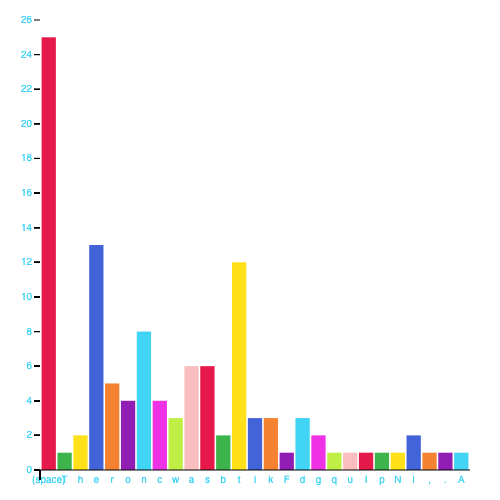

{
  "Chart Generator": {
    messages: [
      HumanMessage {
        lc_serializable: true,
        lc_kwargs: {
          content: "The bar chart representing the frequency of each character's appearance in the provided limerick has"... 136 more characters,
          name: "ChartGenerator",
          additional_kwargs: {}
        },
        lc_namespace: [ "langchain_core", "messages" ],
        content: "The bar chart representing the frequency of each character's appearance in the provided limerick has"... 136 more characters,
        name: "ChartGenerator",
        additional_kwargs: {}
      }
    ]
  }
}
---
{
  supervisor: {
    next: "FINISH",
    instructions: "The conversation has concluded with all tasks completed successfully."
  }
}
---


In [27]:
const resultStream = authoringChain.stream(
  { messages: [new HumanMessage("Write a limerick and make a bar chart of the characters used.")] },
  { recursionLimit: 100 }
);

for await (const step of await resultStream) {
  if (!step?.__end__){
    console.log(step);
    console.log("---");
  }
}
    

You can [click here](https://smith.langchain.com/public/ee1549c6-0095-4806-9259-ead0946503f5/r) to see a representative LangSmith trace of the above run.

## Add Layers

In this design, we are enforcing a top-down planning policy. We've created two graphs already, but we have to decide how to route work between the two.

We'll create a _third_ graph to orchestrate the previous two, and add some connectors to define how this top-level state is shared between the different graphs.

In [28]:
import { BaseMessage } from "@langchain/core/messages";
import { ChatOpenAI } from "@langchain/openai";
import { RunnableLambda } from "@langchain/core/runnables";

// Define the top-level State type
interface State {
  messages: BaseMessage[];
  next: string;
  instructions: string;
}

const llm = new ChatOpenAI({ modelName: "gpt-4-1106-preview" });

const supervisorNode = await createTeamSupervisor(
  llm,
  "You are a supervisor tasked with managing a conversation between the" +
    " following teams: {team_members}. Given the following user request," +
    " respond with the worker to act next. Each worker will perform a" +
    " task and respond with their results and status. When finished," +
    " respond with FINISH.\n\n" + 
    " Select strategically to minimize the number of steps taken.",
  ["Research team", "Paper writing team"],
);

const getMessages = RunnableLambda.from((state: State) => {
  return { messages: state.messages }
});

const joinGraph = RunnableLambda.from((response: any) => {
  return {
    messages: [response.messages[response.messages.length - 1]]
  };
});


Now we can finally create the top-level graph below.

In [29]:
const superGraph = new StateGraph<State>({
  channels: {
    messages: {
      value: (x: BaseMessage[], y: BaseMessage[]) => x.concat(y),
      default: () => [],
    },
    next: "Research team",
    instructions: "Solve the user's request."
  }
});

superGraph.addNode("Research team", getMessages.pipe(researchChain).pipe(joinGraph));
superGraph.addNode("Paper writing team", getMessages.pipe(authoringChain).pipe(joinGraph));
superGraph.addNode("supervisor", supervisorNode);

superGraph.addEdge("Research team", "supervisor");
superGraph.addEdge("Paper writing team", "supervisor");
superGraph.addConditionalEdges(
  "supervisor",
  (x) => x.next,
  {
    "Paper writing team": "Paper writing team",
    "Research team": "Research team",
    "FINISH": END
  }
);

superGraph.setEntryPoint("supervisor");
const compiledSuperGraph = superGraph.compile();

With the full graph defined, try invoking it!

{
  supervisor: {
    next: "Research team",
    instructions: "Look up a current event that is relevant and can be used as a topic for writing a poem."
  }
}
---
{
  "Research team": {
    messages: [
      HumanMessage {
        lc_serializable: true,
        lc_kwargs: {
          content: "The task of writing a poem inspired by the recent current event of the Mississippi tornado on April "... 290 more characters,
          name: "Search",
          additional_kwargs: {}
        },
        lc_namespace: [ "langchain_core", "messages" ],
        content: "The task of writing a poem inspired by the recent current event of the Mississippi tornado on April "... 290 more characters,
        name: "Search",
        additional_kwargs: {}
      }
    ]
  }
}
---
{
  supervisor: {
    next: "Paper writing team",
    instructions: "Plot a bar chart of the distribution of words in the poem written about the Mississippi tornado even"... 2 more characters
  }
}
---


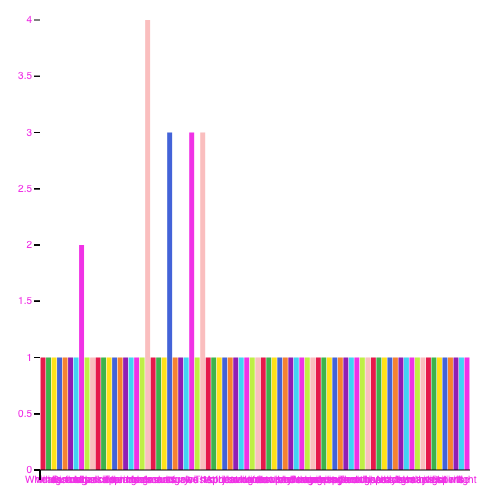

{
  "Paper writing team": {
    messages: [
      HumanMessage {
        lc_serializable: true,
        lc_kwargs: {
          content: "The requested task of creating a bar chart that represents the distribution of word frequencies from"... 104 more characters,
          name: "ChartGenerator",
          additional_kwargs: {}
        },
        lc_namespace: [ "langchain_core", "messages" ],
        content: "The requested task of creating a bar chart that represents the distribution of word frequencies from"... 104 more characters,
        name: "ChartGenerator",
        additional_kwargs: {}
      }
    ]
  }
}
---
{
  supervisor: {
    next: "FINISH",
    instructions: "All parts of the task have been completed, and no further action is needed."
  }
}
---


In [30]:
const resultStream = compiledSuperGraph.stream(
  {
    messages: [
      new HumanMessage(
        "Look up a current event, write a poem about it, then plot a bar chart of the distribution of words therein."
      )
    ],
  },
  { recursionLimit: 150 }
);

for await (const step of await resultStream) {
  if (!step.__end__) {
    console.log(step);
    console.log("---");
  }
}

As before, you can [click here](https://smith.langchain.com/public/067e1ef5-f48a-4f44-8750-c5ef5da4fdb4/r) to see a LangSmith run of the above graph.